# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *

import jax
import mrcfile
from jax.scipy.special import gammaln

plt.rcParams["figure.figsize"]=6,6

### Read the data

In [3]:
# Out directory to save outputs
out_dir = '../data/out_dev/'

In [4]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
#star_file = "/Extract/job018/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/3DFSC_data/untilted/Particle-Stack/"
#star_file = "T40_HA_130K-Equalized_run-data.star"
#star_file = "T00_HA_130K-Equalized_run-data.star"

#data_dir = "/gpfs/gibbs/pi/lederman/EMPIAR-10028/"
#star_file = "shiny_2sets.star"


data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "particles_crossvalidation_train_1.star"
star_file = "particles_subset_5k.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "Projections/crossvalidation1_sub/crossvalidation1_sub.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/SimulatedData/"
#star_file = "random_particles_128.star"

#data_dir = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset40k/mixed_noisy/"
#star_file = "particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/EMPIAR-10028/"
#star_file = "shiny_2sets.star"
#star_file = "particles2.star"

#dataset_name = "exp_data"
#data_dir = "/gpfs/gibbs/pi/lederman/bt387/exp_data/"
#star_file = "particles1.star"

#dataset_name = "cryodrgn_noisy"
#data_dir = f"/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset20k/{dataset_name}/"
#star_file = "particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  5000
load_data: data loaded, time:  28.148998260498047


### Preprocess the images

i.e. downsample, shuffle, compute grid, mask, estimate noise.

In [5]:
nx_crop = 64
N = 3000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (5000, 320, 320)
pixel_size0.shape = (5000,)
angles0.shape = (5000, 3)
shifts0.shape = (5000, 2)
ctf_params0.shape = (5000, 9)
Shuffle = False
N = 3000
Taking FFT of the images...done. Time: 8.20762825012207 seconds.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 6.40000000e+01]
Vectorised imgs_f.shape = (3000, 4096)
Mask radius = 0.0739503816793893
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time: 7.128161191940308 seconds.


### Plot a few things

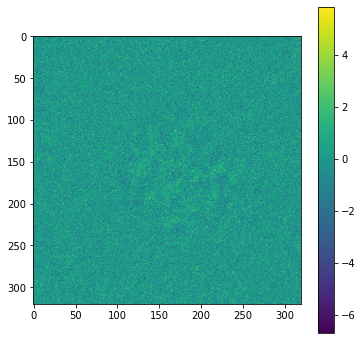

In [6]:
plt.imshow(imgs0[1]); plt.colorbar()

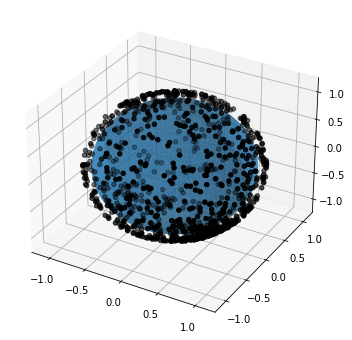

In [7]:
plot_angles(angles[np.random.permutation(imgs_f.shape[0]-1)[:1000]])

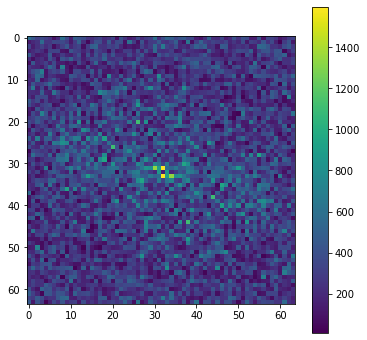

In [8]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[103].reshape([nx,nx])))); plt.colorbar()

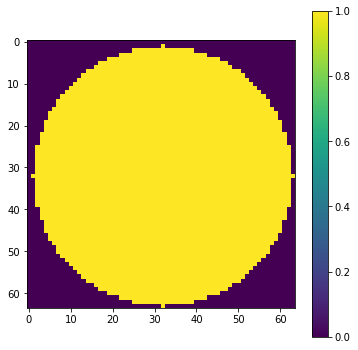

In [9]:
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

Text(0.5, 1.0, 'Estimated noise')

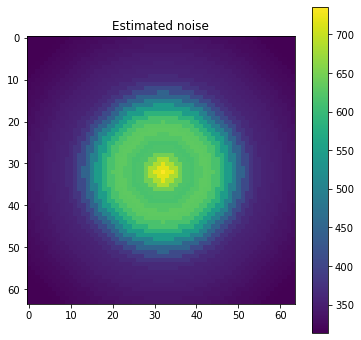

In [10]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()
plt.title('Estimated noise')

#### Delete the real images
Since we only work with the Fourier ones from now on.

In [11]:
del(imgs0)
#del(imgs)

### Ab initio

Actual pixel size for 32 x 32 images is:

In [17]:
pixel_size[0]*(320/nx)

6.550000000000001

In [18]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


In [19]:
320*pixel_size[0]

419.20000000000005

In [20]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
pixel_size_nx = pixel_size[0] * 320/nx

B = pixel_size[0] * 320/8
sh = random.uniform(key, (N, 2)) * 2*B - B

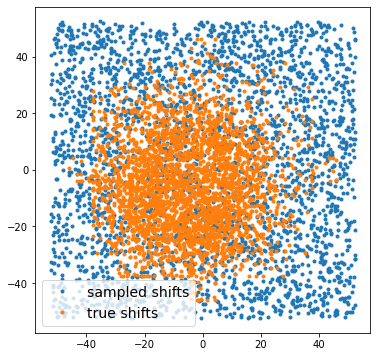

In [21]:
plt.plot(sh[:,0], sh[:,1], '.')
plt.plot(shifts[:,0], shifts[:,1],'.')
lgd = plt.legend(['sampled shifts', 'true shifts'], fontsize=14)

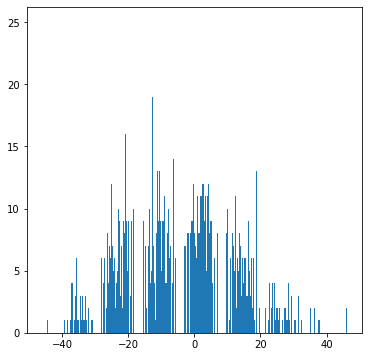

In [22]:
nbins=1000
counts, bins = np.histogram(shifts[:,0], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

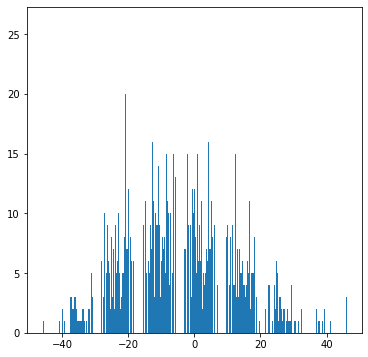

In [23]:
nbins=1000
counts, bins = np.histogram(shifts[:,1], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [24]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [25]:
#sys.stdout = sys.__stdout__

In [26]:
#v_rec_int = v_rec
#angles_rec_int = angles_rec

In [27]:
# Split in batches, note that imgs_batch stays on the CPU (i.e. np not jnp)
N_batch = 1
imgs_batch = np.array(np.array_split(imgs_f, N_batch))
angles_batch = jnp.array(np.array_split(angles, N_batch))
shifts_batch = jnp.array(np.array_split(shifts, N_batch))
ctf_params_batch = jnp.array(np.array_split(ctf_params, N_batch))

In [28]:
keys = random.split(key, 4)

In [29]:
keys

DeviceArray([[3890300668, 3959371569],
             [4030116142,  277345343],
             [3336551039,  639656104],
             [3639883912, 2287815400]], dtype=uint32)

In [30]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

# The number of iterations desn't matter, 
# since it stops when the volume is nx x nx x nx.
N_iter = 100000000000

#radius0 =  0.15 #0.15  #0.06
#radius0 = 0.010
radius0 = 0.01
#radius0 = 0.04 #0.05
alpha = 1e-9  # <--- this is the working one
#alpha = 1e-6

sgd_batch_size = 300
sgd_learning_rate = 10 #1e5 #1e6
eps_init = 1e-8 #2e-7

N_samples_vol = 201   
N_samples_angles_global = 1001
N_samples_angles_local = 201
N_samples_shifts = 101
N_samples_z = 201

# HMC params
#dt = 5
dt_list_hmc = jnp.array([0.1, 0.5, 1, 5, 10])
L_hmc = 5

sigma_perturb_list = jnp.array([1, 0.1, 0.01, 0.001])

pixel_size_nx = pixel_size[0] # * nx0/nx

B = pixel_size[0] * 320/8
B_list = jnp.array([B/2, B/4, B/8, B/16])

minibatch_size = 1000
freq_marching_step_iters = 8

vol0 = None
angles0 = None #angles_batch
shifts0 = None #shifts_batch
z0 = None
#sigma_noise = jnp.ones(sigma_noise.shape)

    
v_rec, angles_rec, shifts_recz = ab_initio_mcmc(key, 
                                                project, 
                                                rotate_and_interpolate,
                                                apply_shifts_and_ctf,
                                                imgs_batch, 
                                                sigma_noise, 
                                                ctf_params_batch, 
                                                x_grid, 
                                                vol0,
                                                angles0,
                                                shifts0,
                                                N_iter, 
                                                sgd_learning_rate, 
                                                sgd_batch_size, 
                                                N_samples_vol,
                                                N_samples_angles_global,
                                                N_samples_angles_local, 
                                                N_samples_shifts,
                                                dt_list_hmc,
                                                sigma_perturb_list,
                                                L_hmc, 
                                                radius0, 
                                                None, 
                                                alpha, 
                                                eps_init,
                                                B,
                                                B_list,
                                                minibatch_size,
                                                freq_marching_step_iters,
                                                'tri', 
                                                True, True, True, True, out_dir)

Fourier radius: 0.07633587786259541
Minibatch factor: 1000
Starting radius: 0.01
Frequency marching step size: 0.004131800590574611
Number of frequency marching steps: 17
Number of iterations: 136
B = 52.400000000000006
B_list = [26.2   13.1    6.55   3.275]
------------------------------------



TypeError: Shapes must be 1D sequences of concrete values of integer type, got [64.0, 64.0].

In [ ]:
plot_angles(angles_rec[:2000])

In [ ]:
v_final = mrcfile.open(f"{out_dir}/rec_final.mrc").data
v_rec, _, _ = volume_fourier(v_final, pixel_size[0])
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,:,0])))

In [ ]:
with open(f"{out_dir}/rec_iter_53_angles", 'rb') as file:
    # Call load method to deserialze
    angles_rec = pickle.load(file)
    angles_rec = angles_rec[0]

In [ ]:
plot_angles(angles_rec)

In [ ]:
theta, cord_distance = err_orientations(angles, angles_rec)

nbins=100
counts, bins = np.histogram(theta, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
v_rec_l, x_grid_l = rescale_larger_grid(v_rec, x_grid, 256)
v_rec_rl = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l)))
mip_z(v_rec_rl)
plt.colorbar()


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_alpha1e-9_nx0_ab_initio.mrc", overwrite=True) as mrc:
    mrc.set_data(v_rec_rl.astype(np.float32))

In [ ]:
out_dir

In [ ]:
with open(f"{out_dir}/idxrand", 'rb') as file:
    # Call load method to deserialze
    idxrand = pickle.load(file)
    #z_rec = angles_rec[0]

In [ ]:
angles_rec.shape

In [ ]:
a1prev

In [ ]:
plt.rcParams["figure.figsize"]=12,6

a1prev = a1


with open(f"{out_dir}/rec_iter_45_angles", 'rb') as file:
    # Call load method to deserialze
    #z_rec = pickle.load(file)
    angles_rec = pickle.load(file)[0]
    a1 = angles_rec[:,0]
    
    
diff= a1-a1prev

plt.plot(diff[:100])





#prevdiff = diff
#diff = z[idxrand]-z_rec
#plt.plot(diff[:100])
#plt.plot(prevdiff[:100])


#print(jnp.sum(diff-prevdiff != 0))

In [ ]:
jnp.sum(z[idxrand[:N]]-z_rec != 0)

In [ ]:
nbins=100
counts, bins = np.histogram(z_rec, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
idxrand

### MCMC vol

In [ ]:
with open("/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1_shifts_32_latest/rec_iter_704_angles", 'rb') as file:
    # Call load method to deserialze
    #z_rec = pickle.load(file)
    angles = pickle.load(file)[0]
   
with open("/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1_shifts_32_latest/rec_iter_704_shifts", 'rb') as file:
    # Call load method to deserialze
    #z_rec = pickle.load(file)
    shifts = pickle.load(file)[0]

In [ ]:
with mrcfile.open("/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1_shifts_32_latest/rec_iter_704.mrc") as file:
    vol0 = file.data
   
vol0, _, _= volume_fourier(vol0, 1)

print(f"vol.shape = {vol0.shape}")
plt.imshow(np.abs(jnp.fft.fftshift(vol0[0]))); plt.colorbar()

In [ ]:
angles_rec = angles

In [ ]:
plot_angles(angles[:1000])

In [ ]:
jnp.max(shifts)

In [ ]:
jnp.min(shifts0)

In [ ]:
plt.plot(shifts[:,0], shifts[:,1],'.')
plt.plot(shifts0[:,0], shifts0[:,1],'.')

jnp.sum(jnp.abs(shifts))

In [ ]:
B0

In [ ]:


B = pixel_size[0] * 320/8
ssh = random.uniform(key, (40000,2))*2*B-B
#ssh = random.normal(key,  (40000,2))*B0

plt.plot(shifts[:,0], shifts[:,1], '.')
plt.plot(ssh[:,0], ssh[:,1], '.')

In [ ]:
nbins=200
counts, bins = np.histogram(shifts, bins=nbins)

nbins=100
counts2, bins2 = np.histogram(ssh, bins=nbins)

_ = plt.hist(bins2[:-1], bins2, weights=counts2)
_ = plt.hist(bins[:-1], bins, weights=counts)


In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


samp = random.normal(key, (10000,)) * B/16

nbins=100
counts, bins = np.histogram((samp), bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
#ctf_nones = []
#for i in range(N):
#    ctf_nones.append(None)
#ctf_params = jnp.array(ctf_nones)  

In [ ]:
#import gc
#gc.collect()

In [ ]:
imgs_f_full = imgs_f
angles_full = angles
shifts_full = shifts
ctf_params_full = ctf_params

In [ ]:
#N = 1000
#imgs_f = imgs_f_full[:N]
#angles = angles_full[:N]
#shifts = shifts_full[:N]
#ctf_params = ctf_params_full[:N]

In [ ]:
print(f"angles.shape = {angles.shape}")
print(f"imgs_f.shape = {imgs_f.shape}")

In [ ]:
N_batch = 10
imgs_batch = np.array(np.array_split(imgs_f, N_batch))
angles_batch = np.array(np.array_split(angles, N_batch))
shifts_batch = np.array(np.array_split(shifts, N_batch))
ctf_params_batch = np.array(np.array_split(ctf_params, N_batch))

In [ ]:
vol0 = vol0.astype(jnp.complex128)

In [ ]:
alpha = 1e-9
#alpha = 1e-6
#alpha=1e-7

#radius = 0.048# for nx=32
radius = 0.075 *1.31
#radius = 0.185
#radius = 1.6 # for nx=64
#radius = 0.198 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 5

pixel_size_nx = pixel_size[0] * 320/nx
B = pixel_size[0] * 320/4
B_list = jnp.array([B/16])

@jax.jit
def rotate_and_interpolate_iter(v, angles):
    return jax.vmap(rotate_and_interpolate, in_axes=(None,0,None,None))(v, angles, x_grid, x_grid)

slice_func, _, _ = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, _, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
_, loss_func_batched0, _ = get_loss_funcs(slice_func, alpha = 0)

grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

loss_proj_func_batched0 = get_loss_proj_funcs(apply_shifts_and_ctf, x_grid, alpha = 0)

proposal_func_orientations_u, proposal_func_orientations_p, proposal_func_shifts, proposal_func_vol, proposal_func_vol_batch, proposal_func_mtm_orientations_shifts = get_jax_proposal_funcs(
    loss_func_batched0, loss_proj_func_batched0, loss_func_sum, grad_loss_volume_sum, rotate_and_interpolate_iter,
    sigma_noise, B, B_list, dt_list, L, M) 

#logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_rec, ctf_params, imgs_f, sigma_noise)
#gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts_rec, ctf_params, imgs_f, sigma_noise))


In [ ]:
N_mc_samples = 10
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

#v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
#v0 = jnp.zeros([nx,nx,nx])*1j
#v0 = v_rec
#v0 = v_hmc_mean

#v0 = vol0.astype(jnp.complex128)

params_vol = {'angles': angles_batch, 
              'shifts': shifts_batch, 
              'ctf_params': ctf_params_batch, 
            'imgs_iter': imgs_batch}

t0 = time.time()
v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, proposal_func_vol_batch, vol0, N_mc_samples, params_vol, save_samples=-1, iter_display=1)
print(time.time()-t0)


In [ ]:
r_hmc.shape

In [ ]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_samples[0,:,:,0]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

In [ ]:
#v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_samples[0])))
#v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol0)))

mip_z(v_hmc_r)
plt.colorbar()


In [ ]:
with mrcfile.new(f"{out_dir}/v_hmc_mean.mrc", overwrite=True) as mrc:
#with mrcfile.new("/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem2_switch/rec_final_opt.mrc", overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

In [ ]:
v_hmc_mean_l, x_grid_l = rescale_larger_grid(v_hmc_samples[0], x_grid, 320)
#v_hmc_mean_l, x_grid_l = rescale_larger_grid(v_hmc_mean, x_grid, 320)
v_hmc_rl = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean_l)))
mip_z(v_hmc_rl)
plt.colorbar()


In [ ]:
with mrcfile.new(f"{out_dir}/v_hmc_mean_nx0.mrc", overwrite=True) as mrc:
#with mrcfile.new("/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem2_switch/rec_final_opt_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(v_hmc_rl.astype(np.float32))
    


In [ ]:
file = open('../data/cryodrgn/angles_rec', 'wb')
pickle.dump(angles_rec, file)
file.close()

file3 = open('../data/cryodrgn/shifts_rec','wb')
pickle.dump(shifts_rec, file3)
file3.close()

In [ ]:
with open('../data/cryodrgn5000/angles_rec', 'rb') as file:
    # Call load method to deserialze
    angles_rec2 = pickle.load(file)
    
with open('../data/cryodrgn5000/shifts_rec', 'rb') as file:
    # Call load method to deserialze
    shifts_rec2 = pickle.load(file)
    
with open('../data/cryodrgn5000/angles_rec_img_idx', 'rb') as file:
    # Call load method to deserialze
    idxrand2 = pickle.load(file)    
    

In [ ]:
jnp.sum(jnp.abs(angles_rec2 - angles_rec))
jnp.sum(jnp.abs(shifts_rec2 - shifts_rec))
jnp.sum(jnp.abs(idxrand2 - idxrand))

### Global orientations + shifts sampling

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, subkey = random.split(key)

In [ ]:
B = pixel_size[0] * 320/8


In [ ]:
B

In [ ]:
B = pixel_size[0] * 320/8

@jax.jit
def proposal_func_mtm_orientations_shifts_this(key, as0, logPiX0, v, ctf_params, imgs_iter):
    key, *keys = random.split(key, 4)

    angles0 = as0[:,:3]
    shifts0 = as0[:,3:]

    angles1 = generate_uniform_orientations_jax(keys[0], angles0)
    #angles1 = angles0
    proj = rotate_and_interpolate_iter(v, angles1)

    N_samples_shifts = 2000
    N = angles0.shape[0]
    #B0 = random.permutation(keys[1], B_list)[0]
    #shifts1_states = random.normal(keys[2],  (N,N_samples_shifts,2))*B
    shifts1_states = random.uniform(keys[2], (N, N_samples_shifts,2)) * 2 * B - B


    #s1 = np.linspace(-B,B,40)
    #s1x, s1y = jnp.meshgrid(s1,s1)
    #shifts1_states = jnp.array([s1x.ravel(), s1y.ravel()]).transpose()
    #shifts1_states = jnp.repeat(jnp.expand_dims(shifts1_states, 0), N, 0)

    # weights has shape [N, N_samples_shifts], w(y_i) = logPi(y_i)
    weights = -jax.vmap(loss_proj_func_batched0, in_axes=(None,None,1,None,None,None))(v, proj, shifts1_states, ctf_params, imgs_iter, sigma_noise).transpose()
    
    #print(imgs_iter.shape)
    #print(ctf_params.shape)
    
    print(shifts1_states)
    print(f"weights.shape = {weights.shape}")
    #plt.plot(weights[0])
    #plt.plot(weights[1])

    # Select the proposed state with probability proportional
    # to weights, batch mode (all images in parallel).
    keys = random.split(key, N)
    sh1idx = jax.vmap(jax.random.categorical, in_axes=(0,0))(keys, weights)
    
    print(f"sh1idx = {sh1idx}")
    shifts1 = jax.vmap(lambda s1_states_i, sh1idx_i : s1_states_i[sh1idx_i], in_axes=(0,0))(shifts1_states, sh1idx)
    # The weights corresponding to proposed state (angles1,shifts1) (i.e. logPiX1)
    weights1 = jax.vmap(lambda weights_i, sh1idx_i : weights_i[sh1idx_i], in_axes=(0,0))(weights, sh1idx)

    weights0 = -loss_func_batched0(v,angles0,shifts0,ctf_params,imgs_iter,sigma_noise)
    weights_reference = jax.vmap(lambda weights_i, sh1idx_i, w0_i : weights_i.at[sh1idx_i].set(w0_i), in_axes = (0,0,0))(weights, sh1idx, weights0)
 
    print(f"weights0.shape = {weights0.shape}")
    print(f"weights1.shape = {weights1.shape}")
    
    print(f"weights.shape = {weights.shape}")
    print(f"weights_reference.shape = {weights_reference.shape}")

    r = jax.vmap(ratio_sum_exp, in_axes=(0,0))(weights, weights_reference)

    print(f"Proposed shifts: = {shifts1}")    
    print(f"r = {r}")
    
    as1 = jnp.concatenate([angles1,shifts1], axis=1)

    return as1, r, weights1, weights0

@jax.jit
def ratio_sum_exp(a, b):
    """Given two arrays a=[A1, ..., An], b=[B1,..., Bn],
    compute the ratio sum(exp(a1)) / sum(exp(a2)) in a way
    that doesn't lead to nan's."""

    log_ratio = a[0] - b[0] \
        + jnp.log(jnp.sum(jnp.exp(a-a[0]))) \
        - jnp.log(jnp.sum(jnp.exp(b-b[0])))

    return jnp.exp(log_ratio)

In [ ]:
# Volume obtained form sampling in the previous section

angles_true = angles
shifts_true = shifts
vol = v_hmc_mean

In [ ]:
proposal_func_orientations_u, proposal_func_orientations_p, proposal_func_shifts, proposal_func_vol, proposal_func_vol_batch, proposal_func_mtm_orientations_shifts = get_jax_proposal_funcs(
    loss_func_batched0, loss_proj_func_batched0, loss_func_sum, grad_loss_volume_sum, 
    rotate_and_interpolate_iter, sigma_noise, B, B_list, dt_list, L, M) 

In [ ]:
B

In [ ]:
shifts_true

In [ ]:
#as0 = jnp.concatenate([angles, shifts], axis=1)
#as1, r, w1, w0 = proposal_func_mtm_orientations_shifts(key, as0, jnp.inf*jnp.ones(N), vol, ctf_params, imgs_f)

In [ ]:
NN = 100

N_mc_samples = 1000
#key, subkey = random.split(key)

params = {'v': vol, 
        'ctf_params': ctf_params[:NN], 
        'imgs_iter': imgs_f[:NN]}
          
as0 = jnp.array(np.random.randn(NN,5))

#as0 = jnp.concatenate([angles_true[:NN], shifts_true[:NN]], axis=1)

t0 = time.time()
_, angles_shifts_r, angles_shifts_samples = mcmc(key, proposal_func_mtm_orientations_shifts_this, as0, N_mc_samples, params, NN, save_samples=-1, iter_display=50)
print(time.time()-t0)

angles_rec = angles_shifts_samples[0, :, :3]
shifts_rec = angles_shifts_samples[0, :, 3:]

In [ ]:
as0[0,3:]

In [ ]:
print(shifts_rec[0])
print(shifts_true[0])

In [ ]:
print(shifts_rec[1])
print(shifts_true[1])

In [ ]:
np.linspace(-B,B,40)

In [ ]:
angles_shifts_r.shape

In [ ]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.plot(angles_shifts_r[:,0])

plt.subplot(1,2,2)
plt.plot(angles_shifts_r[:,1])

plt.rcParams["figure.figsize"]=6,6

In [ ]:
idx = 0
print(shifts_rec[idx])
print(shifts[idx])

print(angles_rec[idx])
print(angles[idx])

In [ ]:
plt.plot(shifts[:NN,0], shifts[:NN,1], '.')
plt.plot(shifts_rec[:,0], shifts_rec[:,1], '.')

In [ ]:
nbins=100
counts, bins = np.histogram(shifts, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
B

In [ ]:
theta, cord_distance = err_orientations(angles[:NN], angles_rec)

nbins=100
counts, bins = np.histogram((theta), bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
plt.plot(jnp.sort(cord_distance))

In [ ]:
theta, cord_distance = err_orientations(angles[:NN], as0[:,:3])

nbins=100
counts, bins = np.histogram((theta), bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
plt.plot(jnp.sort(cord_distance))

### HMC orientations

In [ ]:
def get_grad_angles_funcs(loss_func):
    
    @jax.jit
    def grad_loss_angles(v, angles, shifts, ctf_params, img, sigma):
        return jax.grad(loss_func, argnums = 1)(v, angles, shifts, ctf_params, img, sigma)
    
    @jax.jit 
    def grad_loss_angles_batched(v, angles, shifts, ctf_params, imgs, sigma):
        return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0, 0, 0, None))(v, angles, shifts, ctf_params, imgs, sigma)
    
    return grad_loss_angles, grad_loss_angles_batched

In [ ]:
grad_loss_angles, grad_loss_angles_batched = get_grad_angles_funcs(loss_func)

In [ ]:
print(v_hmc_mean.shape)
print(angles.shape)
print(shifts.shape)
print(ctf_params.shape)
print(imgs_f.shape)

In [ ]:
grad_ang = grad_loss_angles(v_hmc_mean, angles[0], shifts[0], ctf_params[0], imgs_f[0], sigma_noise)

print(grad_ang.shape)
print(grad_ang)

In [ ]:
N = 1000

t0 = time.time()
grads_ang = grad_loss_angles_batched(v_hmc_mean, angles[:N], shifts[:N], ctf_params[:N], imgs_f[:N], sigma_noise)
print(f"{time.time()-t0} seconds")

print(grads_ang.shape)
#print(grads_ang)

### MCMC local shifts

In [ ]:
sh0 = shifts_batch

In [ ]:
sh0[0]

In [ ]:
N_mc_samples = 100
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, subkey = random.split(key)


proj = jnp.array([rotate_and_interpolate_iter(vol0, angles_batch[i]) for i in jnp.arange(angles_batch.shape[0])])

sh0 = shifts_new

shifts_new = []
N_batch = shifts_batch.shape[1]


for i in jnp.arange(shifts_batch.shape[0]):
    print(f"Batch {i}")
    
    params_shifts = {'v': vol0, 
                  'proj': proj[i], 
                  'ctf_params': ctf_params_batch[i], 
                'imgs_iter': imgs_batch[i]}

    t0 = time.time()
    _, shifts_r, shifts_samples = mcmc(key, proposal_func_shifts, sh0[i], N_mc_samples, params_shifts, N_batch, save_samples=1, iter_display=10)
    print(time.time()-t0)

    shifts_new.append(shifts_samples[N_mc_samples-2])
    
shifts_new = jnp.array(shifts_new)

### MCMC local perturbations for orientations

In [ ]:
#Load a volume
#vol_file = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/Refine3D/crossvalidation1/run_class001.mrc"
#
#with mrcfile.open(vol_file) as file:
#    v_r = file.data
#    
#v, _, _ = volume_fourier(v_r, 1)
#mip_z(jnp.fft.fftshift(jnp.abs(v))); plt.colorbar()

In [ ]:
angles_batch.shape

In [ ]:
#a0 = generate_uniform_orientations_jax(subkey, jnp.zeros(N))
a0 = angles_batch
v = vol0

In [ ]:
print(a0[0])
idx_batch = 0

key, subkey = random.split(key)
a1, _, _, _= proposal_func_orientations_p(subkey, a0[idx_batch], jnp.inf*jnp.ones(shifts_batch.shape[1]), v, shifts_batch[idx_batch], ctf_params_batch[idx_batch], imgs_batch[idx_batch], jnp.array([0.01]))
print(a1[0])

In [ ]:
shifts_batch.shape

In [ ]:
N_mc_samples = 10
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, subkey = random.split(key)

sigma_perturb_list = jnp.array([1, 0.1, 0.01, 0.001])

angles_new = []
N_batch = shifts_batch.shape[1]

for i in jnp.arange(shifts_batch.shape[0]):
    print(f"Batch {i}")
    
    params_angles = {'v': v, 
                  'shifts': shifts_new[i], 
                  'ctf_params': ctf_params_batch[i], 
                'imgs_iter': imgs_batch[i],
                 'sigma_perturb' : sigma_perturb_list}

    t0 = time.time()
    _, angles_r, angles_samples = mcmc(key, proposal_func_orientations_p, a0[i], N_mc_samples, params_angles, N_batch, save_samples=1, iter_display=1)
    print(time.time()-t0)

    angles_new.append(angles_samples[N_mc_samples-2])
    
angles_new = jnp.array(angles_new)

In [ ]:
angles_samples.shape

In [ ]:
img_idx = 101
ang_idx = 2

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(angles_samples[:, img_idx, 0], angles_samples[:, img_idx, 1], angles_samples[:, img_idx, 2] )
plt.show()

In [ ]:
nbins=200
counts0, bins0 = np.histogram(angles_samples[:, img_idx, 0], bins=nbins)
_ =plt.hist(bins0[:-1], bins0, weights=counts0)

counts1, bins1 = np.histogram(angles_samples[:, img_idx, 1], bins=nbins)
_ =plt.hist(bins1[:-1], bins1, weights=counts1)

counts2, bins2 = np.histogram(angles_samples[:, img_idx, 2], bins=nbins)
_ =plt.hist(bins2[:-1], bins2, weights=counts2)


In [ ]:

plt.plot(jnp.mod(jnp.abs(angles_samples[:,img_idx,ang_idx] - angles[img_idx,ang_idx]), 2*jnp.pi))

In [ ]:
plt.plot(jnp.mod(jnp.abs(angles_samples[:,img_idx,ang_idx] - angles_rec[img_idx,ang_idx]), 2*jnp.pi))

In [ ]:
theta, cord_distance = err_orientations(angles, angles_rec)

nbins=100
counts, bins = np.histogram(theta, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
theta, cord_distance = err_orientations(angles, angles_rec2)

nbins=100
counts, bins = np.histogram(theta, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
theta, cord_distance = err_orientations(angles_rec, angles_rec2)

nbins=100
counts, bins = np.histogram(theta, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### CG - choosing $\alpha$

In [ ]:
centre = (0,0,0)
#radius = 0.045
radius = 0.093
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [ ]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

In [ ]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [ ]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_iter = 50100
eps = 1e-4
#eps = 1e-5
#eps = 1e-3
#eps = 1e-6
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [ ]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [ ]:
mask.shape

In [ ]:
def pixel_wise_fid_fun(v, slice_func_array, angles, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [ ]:
alphas[alpha_idx]

In [ ]:
sigma_noise1 = jnp.ones(sigma_noise.shape)

In [ ]:
pw_fid = pixel_wise_fid_fun(vcgs[0], slice_func_array, angles, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

In [ ]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [ ]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

In [ ]:
#alpha_idx = 2

In [ ]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

In [ ]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [ ]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [ ]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [ ]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [ ]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 1000)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

In [ ]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [ ]:
jnp.min(jnp.abs(omega))

In [ ]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

In [ ]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

In [ ]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [ ]:
mask2d = mask[:,:,0]
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8, 1e-7]
alphas = [1e-9]

angles_gd = angles

In [ ]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_sum, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

In [ ]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

In [ ]:
alphas[2]

In [ ]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

In [ ]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

In [ ]:
#err = vgds[1] - v_rec
#plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

In [ ]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


In [ ]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [ ]:
idx = 100

In [ ]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([nx,nx])))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()

In [ ]:
def split(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    arr_train = arr[:N2]
    arr_test  = arr[N2:]
    
    return arr_train, arr_test

def split_and_triple(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    arr_train = jnp.tile(arr[:N2], reps=(3,1))
    arr_test  = jnp.tile(arr[N2:], reps=(3,1))
    
    return arr_train, arr_test

def split_and_triple_angles(a):
    N = a.shape[0]
    N2 = jnp.floor(N/2).astype(jnp.int32)

    a_train1 = a[:N2]
    a_train2 = a_train1.copy()
    a_train3 = a_train1.copy()

    a_train2[:,2] += 2*jnp.pi/3
    a_train3[:,2] += 4*jnp.pi/3
   
    a_train = jnp.concatenate([a_train1, a_train2, a_train3], axis=0)
    
    a_test1  = a[N2:]
    a_test2 = a_test1.copy()
    a_test3 = a_test1.copy()

    a_test2[:,2] += 2*jnp.pi/3
    a_test3[:,2] += 4*jnp.pi/3
    
    a_test = jnp.concatenate([a_test1, a_test2, a_test3], axis=0)


    return a_train, a_test

In [ ]:
imgs_train, imgs_test = split_and_triple(imgs_f)
shifts_train, shifts_test = split_and_triple(shifts)
ctf_params_train, ctf_params_test = split_and_triple(ctf_params)
angles_train, angles_test = split_and_triple_angles(angles)
N = imgs_train.shape[0]

#plot_angles(angles[:1000])

In [ ]:
#imgs_train, imgs_test = split(imgs_f)
#shifts_train, shifts_test = split(shifts)
#ctf_params_train, ctf_params_test = split(ctf_params)
#angles_train, angles_test = split(angles)
#N = imgs_train.shape[0]
#plot_angles(angles_train)